<a href="https://www.kaggle.com/code/aliniazi3/spotcancerai?scriptVersionId=240138651" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000


# **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
import os
import itertools
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.impute import SimpleImputer

from glob import glob
from PIL import Image
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# **DATA READING**

In [3]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [5]:
df.shape

(10015, 7)

# **DATA Preprocessing**

**Creating dictionary for displaying more human-friendly labels.**

In [6]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '../input/skin-cancer-mnist-ham10000'

# **Merge images from both folders into one dictionary**

In [7]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# **Creating new columns for better understanding of features**

In [8]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


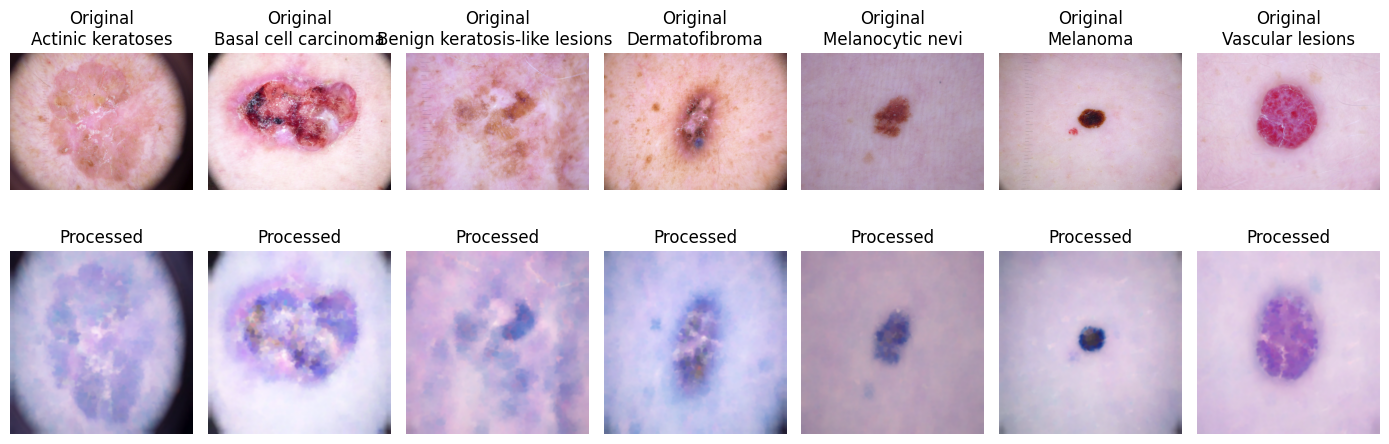

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [9]:
def preprocess_image(image_path, IMAGE_SIZE=456):  
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17)))
    inpainted = cv2.inpaint(img, blackhat, 1, cv2.INPAINT_TELEA)
    denoised = cv2.GaussianBlur(inpainted, (7, 7), 0)
    return denoised


# Drop missing paths
df = df.dropna(subset=['path'])

# Select one sample image per class
sample_images = df.groupby('cell_type').first().reset_index()

plt.figure(figsize=(14, 5))
for i, row in enumerate(sample_images.itertuples(), 1):
    if i > 7: break  # Limit to 7 images
    
    original_image = cv2.imread(row.path)
    processed_image = preprocess_image(row.path)
    
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    plt.subplot(2, 7, i)
    plt.imshow(original_image_rgb)
    plt.title(f"Original\n{row.cell_type}")
    plt.axis("off")
    
    plt.subplot(2, 7, i + 7)
    plt.imshow(processed_image, cmap="gray")
    plt.title("Processed")
    plt.axis("off")

plt.tight_layout()
plt.show()

df.head()

In [10]:
tabular_data = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
tabular_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


# **Exploratory Data Analysis (EDA)**

In [11]:
tabular_data.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [12]:
classes = {4: ('nv', ' melanocytic nevi'), 6: ('mel', 'melanoma'), 2 :('bkl', 'benign keratosis-like lesions'), 1:('bcc' , ' basal cell carcinoma'), 5: ('vasc', ' pyogenic granulomas and hemorrhage'), 0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  3: ('df', 'dermatofibroma')}

# **Frequency Distribution of Classes**

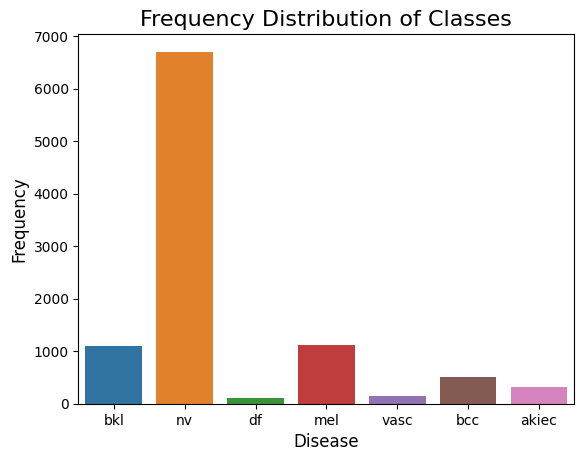

In [13]:
sns.countplot(x = 'dx', data = tabular_data)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)
plt.show()

# **Distribution of Disease over Gender**

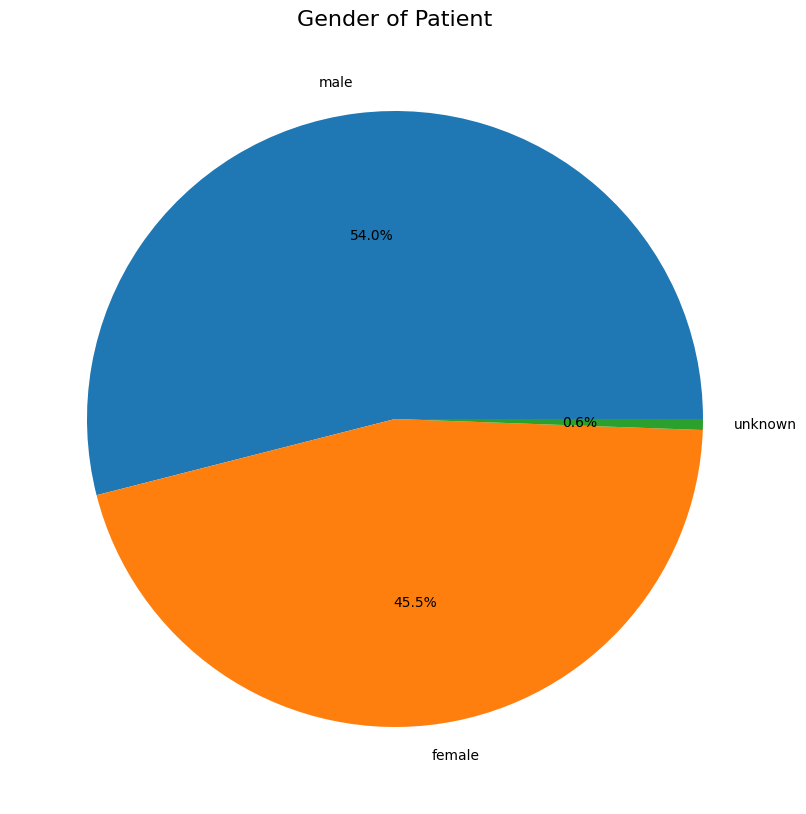

In [14]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(tabular_data['sex'].value_counts(), labels = tabular_data['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)
plt.show()

# **Histogram of Age of Patients**

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


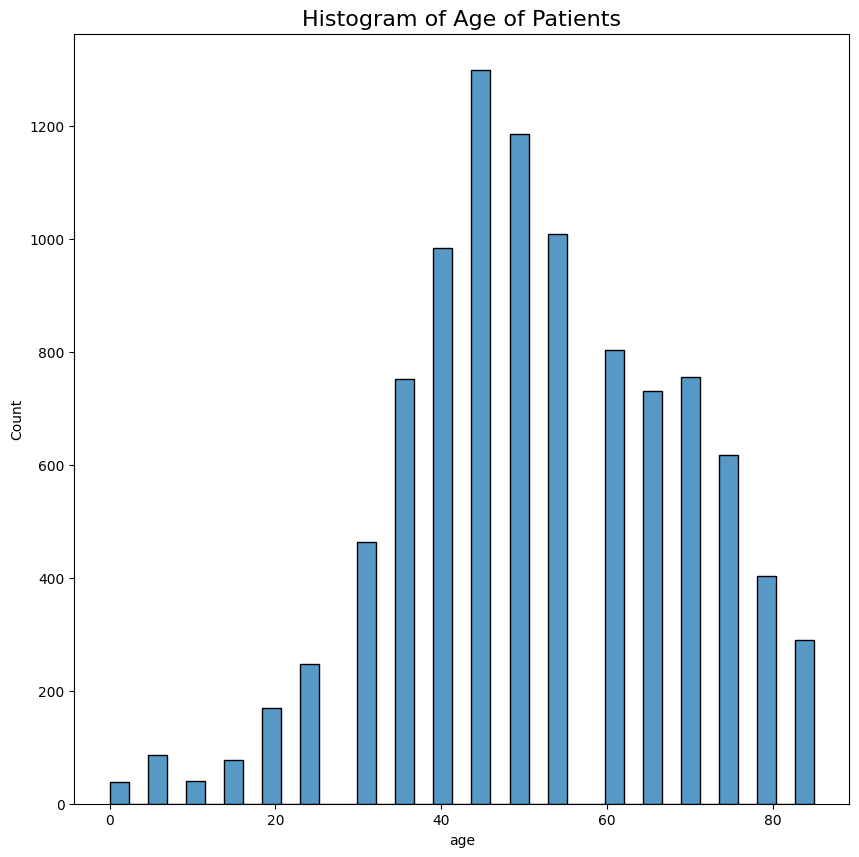

In [15]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(tabular_data['age'])
plt.title('Histogram of Age of Patients', size=16)
plt.show()

# **Location of disease over Gender**

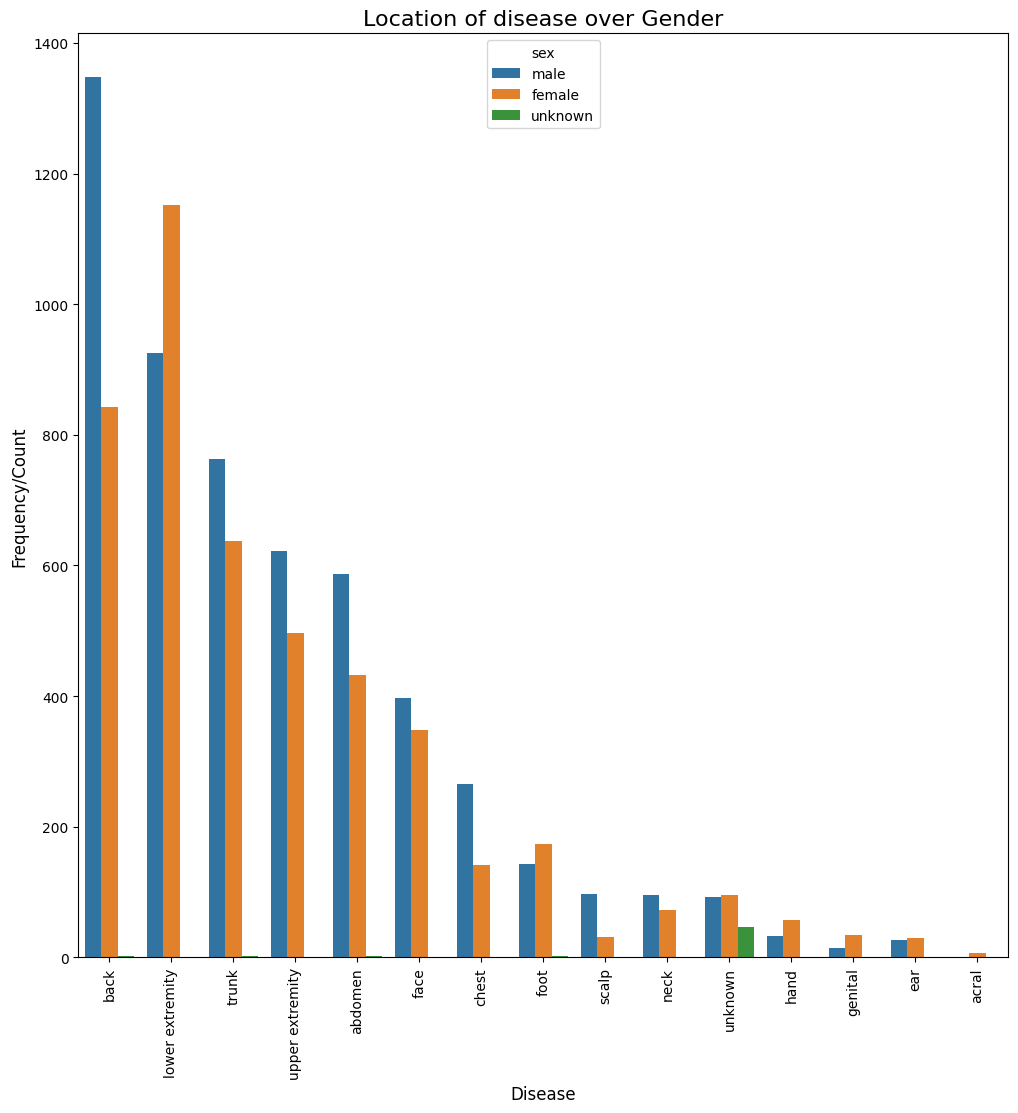

In [16]:
value = tabular_data[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and labels (y)
X = df['path'].values  # Image file paths
y = df['cell_type_idx'].values  # Integer labels for the skin cancer types

# Split the dataset into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Print the size of the splits
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 8012
Test set size: 2003


# **Combine into DataFrames**

In [18]:
# Create train and test DataFrames
train_df = pd.DataFrame({'path': X_train, 'label': y_train})
test_df = pd.DataFrame({'path': X_test, 'label': y_test})

# **Class Balance Through Augmentation**

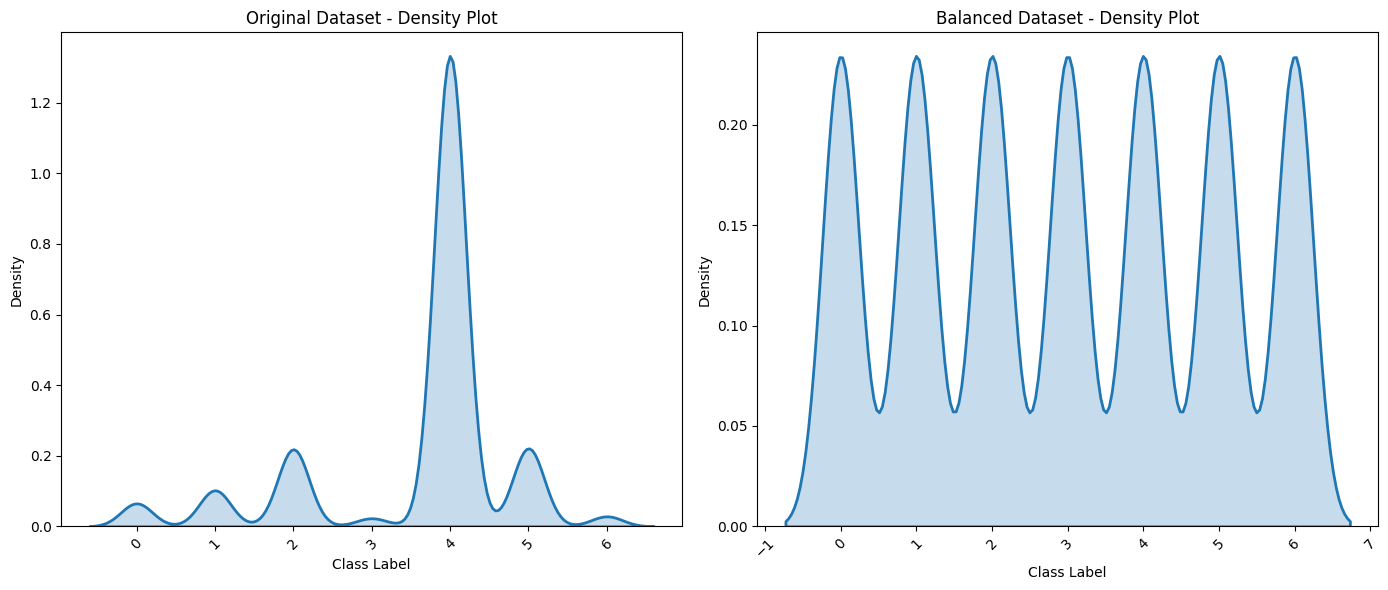

In [19]:
from sklearn.utils import resample
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

max_samples = train_df['label'].value_counts().max()
augmented_dfs = []

for label in train_df['label'].unique():
    df_class = train_df[train_df['label'] == label]
    if len(df_class) < max_samples:
        df_augmented = resample(df_class,
                                replace=True,
                                n_samples=max_samples - len(df_class),
                                random_state=42)
        augmented_dfs.append(df_augmented)

balanced_train_df = pd.concat([train_df] + augmented_dfs, axis=0).reset_index(drop=True)
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

plt.figure(figsize=(14, 6))

# Plot 1: Original dataset
plt.subplot(1, 2, 1)
sns.kdeplot(data=train_df, x='label', fill=True, linewidth=2)
plt.title('Original Dataset - Density Plot')
plt.xlabel('Class Label')
plt.ylabel('Density')
plt.xticks(rotation=45)

# Plot 2: Balanced dataset
plt.subplot(1, 2, 2)
sns.kdeplot(data=balanced_train_df, x='label', fill=True, linewidth=2)
plt.title('Balanced Dataset - Density Plot')
plt.xlabel('Class Label')
plt.ylabel('Density')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# **One-hot encode the labels And Data Generators (for categorical classification)**

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Ensure labels are string type (important for categorical labels)
balanced_train_df['label'] = balanced_train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

IMAGE_SIZE = 456  # EfficientNetB5 input size
BATCH_SIZE = 32
SEED = 42  # for reproducibility

# Data generators with augmentation for training, basic preprocessing for testing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Use balanced_train_df here instead of train_df
train_generator = train_datagen.flow_from_dataframe(
    balanced_train_df,
    x_col='path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)


Found 37548 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


# **Build and compile the EfficientNetB5 model**

In [29]:
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define image size for EfficientNetB5
IMAGE_SIZE = 456  # EfficientNetB5 default input size
# Load EfficientNetB5 without top layer
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all except last 20 layers
    layer.trainable = False
    
# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Build model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 456, 456, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 456, 456, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 456, 456, 3)    │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 456, 456, 3)    │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 457, 457, 3)    │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 228, 228, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 228, 228, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 228, 228, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 228, 228, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 228, 228, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 228, 228, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 29,039,870 (110.78 MB)

 Trainable params: 5,555,335 (21.19 MB)

 Non-trainable params: 23,484,535 (89.59 MB)

# **Train the model**

In [ ]:
warnings.filterwarnings("ignore")
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
)

Epoch 1/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2267s 2s/step - accuracy: 0.5223 - loss: 1.2630 - val_accuracy: 0.6795 - val_loss: 0.8030 - learning_rate: 1.0000e-04
Epoch 2/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2096s 2s/step - accuracy: 0.7715 - loss: 0.6134 - val_accuracy: 0.6885 - val_loss: 0.7736 - learning_rate: 1.0000e-04
Epoch 3/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2106s 2s/step - accuracy: 0.8218 - loss: 0.4855 - val_accuracy: 0.6625 - val_loss: 0.8974 - learning_rate: 1.0000e-04
Epoch 4/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2107s 2s/step - accuracy: 0.8472 - loss: 0.4102 - val_accuracy: 0.6660 - val_loss: 0.8651 - learning_rate: 1.0000e-04
Epoch 5/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2110s 2s/step - accuracy: 0.8659 - loss: 0.3661 - val_accuracy: 0.7564 - val_loss: 0.6876 - learning_rate: 1.0000e-04
Epoch 6/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 2125s 2s/step - accuracy: 0.8780 - loss: 0.3330 - val_accuracy: 0.7179 - val_loss: 0.8283 - learning_rate: 1.0000e-04
Epoch 7/20
1174/1174 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# Example: Find epoch with the highest validation accuracy
best_epoch = np.argmax(history.history['accuracy']) + 1  # +1 because indexing starts from 0
best_acc = history.history['accuracy'][best_epoch - 1]

print(f"Best Epoch: {best_epoch}")
print(f"Accuracy at Best Epoch: {best_acc:.4f}")

In [ ]:
model.save('/kaggle/working/final_model.keras')

# **Plot Training History (Accuracy & Loss)**

In [ ]:
# Training curve
plt.figure(figsize=(14, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss over the ages')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

# Precision curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (training)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Precision over the ages')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


# **Evaluate the Model on Test Data**

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")